In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")

In [2]:
df_raw = pd.read_csv("dirty_cafe_sales.csv")
df = df_raw.copy()
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [3]:
print("Shape (rows, columns):", df.shape)
print("\n📌 Info:")
df.info()

Shape (rows, columns): (10000, 8)

📌 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [4]:
print(f"{df.nunique()}\n")

for col in df.columns:
    print(f"--- {col} ---")
    
    if len(df[col].unique()) > 20:
        print(f"[High Cardinality] Sample: {df[col].unique()[:5]}")
    else:
        print(f"{df[col].unique()}\n")

Transaction ID      10000
Item                   10
Quantity                7
Price Per Unit          8
Total Spent            19
Payment Method          5
Location                4
Transaction Date      367
dtype: int64

--- Transaction ID ---
[High Cardinality] Sample: ['TXN_1961373' 'TXN_4977031' 'TXN_4271903' 'TXN_7034554' 'TXN_3160411']
--- Item ---
['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'UNKNOWN' 'Sandwich' nan
 'ERROR' 'Juice' 'Tea']

--- Quantity ---
['2' '4' '5' '3' '1' 'ERROR' 'UNKNOWN' nan]

--- Price Per Unit ---
['2.0' '3.0' '1.0' '5.0' '4.0' '1.5' nan 'ERROR' 'UNKNOWN']

--- Total Spent ---
['4.0' '12.0' 'ERROR' '10.0' '20.0' '9.0' '16.0' '15.0' '25.0' '8.0' '5.0'
 '3.0' '6.0' nan 'UNKNOWN' '2.0' '1.0' '7.5' '4.5' '1.5']

--- Payment Method ---
['Credit Card' 'Cash' 'UNKNOWN' 'Digital Wallet' 'ERROR' nan]

--- Location ---
['Takeaway' 'In-store' 'UNKNOWN' nan 'ERROR']

--- Transaction Date ---
[High Cardinality] Sample: ['2023-09-08' '2023-05-16' '2023-07-19' '2023-

In [5]:
# Replacing invalid strings
df = df.replace('UNKNOWN', np.nan)
df = df.replace('ERROR', np.nan)

In [6]:
# Changing data type

df['Item'] = df['Item'].astype('category')
df['Quantity'] = df['Quantity'].astype(np.float64) # I will make it int64 leater
df['Price Per Unit'] = df['Price Per Unit'].astype(np.float64)
df['Total Spent'] = df['Total Spent'].astype(np.float64)
df['Payment Method'] = df['Payment Method'].astype('category')
df['Location'] = df['Location'].astype('category')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

In [7]:
# Summary Table
summary = pd.DataFrame({
"dtype": df.dtypes,
"non_null_count": df.count(),
"missing_count": df.isna().sum(),
"missing_percent": df.isna().mean() * 100,
"unique_count": df.nunique()
})

summary.sort_values("missing_percent", ascending=False)

,dtype,non_null_count,missing_count,missing_percent,unique_count
Location,category,6039,3961,39.61,2
Payment Method,category,6822,3178,31.78,3
Item,category,9031,969,9.69,8
Price Per Unit,float64,9467,533,5.33,6
Total Spent,float64,9498,502,5.02,17
Quantity,float64,9521,479,4.79,5
Transaction Date,datetime64[ns],9540,460,4.60,365
Transaction ID,object,10000,0,0.00,10000


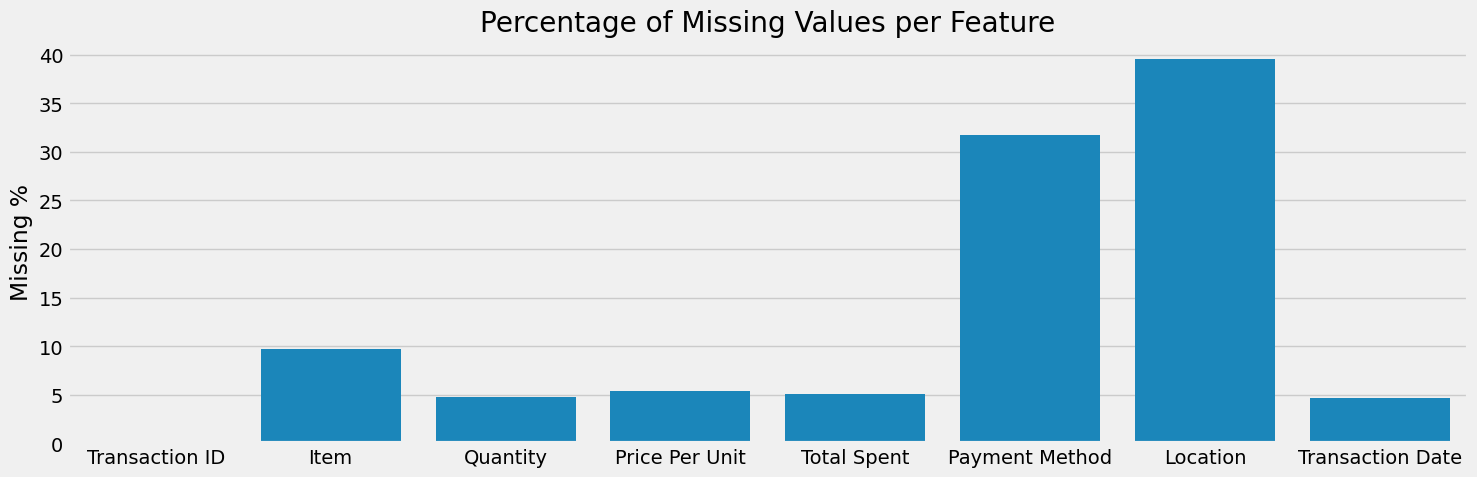

In [8]:
# Percentage of Missing Values per Feature
plt.figure(figsize=(15,5))
sns.barplot(x=summary.index, y=summary['missing_percent'])
plt.title('Percentage of Missing Values per Feature')
plt.xlabel('')
plt.ylabel('Missing %')
plt.tight_layout()
plt.show()

In [9]:
# Fill null items with "Other"
df['Item'] = df['Item'].cat.add_categories('Other').fillna('Other')

In [10]:
# Check for math errors: Total Spent != (Quantity * Price)

errors = df.dropna(subset=['Quantity', 'Price Per Unit', 'Total Spent'])
errors = errors[errors['Total Spent'] != (errors['Quantity'] * errors['Price Per Unit'])]

print(f"Actual math mistakes (excluding missing values): {len(errors)}\n")

print("Missing values (before recovery):")
print(df[['Quantity', 'Price Per Unit', 'Total Spent']].isna().sum())

Actual math mistakes (excluding missing values): 0

Missing values (before recovery):
Quantity          479
Price Per Unit    533
Total Spent       502
dtype: int64


In [11]:
# Deterministic recovery (math)

# Step 1: Recover Total Spent (T = Q * P)
mask_spent = df['Total Spent'].isna() & df['Quantity'].notna() & df['Price Per Unit'].notna()
df.loc[mask_spent, 'Total Spent'] = df['Quantity'] * df['Price Per Unit']

# Step 2: Recover Quantity (Q = T / P)
mask_qty = df['Quantity'].isna() & df['Total Spent'].notna() & df['Price Per Unit'].notna()
df.loc[mask_qty, 'Quantity'] = df['Total Spent'] / df['Price Per Unit']

# Step 3: Recover Price (P = T / Q)
mask_price = df['Price Per Unit'].isna() & df['Total Spent'].notna() & df['Quantity'].notna()
df.loc[mask_price, 'Price Per Unit'] = df['Total Spent'] / df['Quantity']

In [12]:
# The 'True Errors' should still be 0

final_math_check = df.dropna(subset=['Quantity', 'Price Per Unit', 'Total Spent'])
errors = final_math_check[final_math_check['Total Spent'] != (final_math_check['Quantity'] * final_math_check['Price Per Unit'])]

print(f"Post-reconstruction math errors: {len(errors)}\n")

print("Missing values (after recovery):")
print(df[['Quantity', 'Price Per Unit', 'Total Spent']].isna().sum())

Post-reconstruction math errors: 0

Missing values (after recovery):
Quantity          38
Price Per Unit    38
Total Spent       40
dtype: int64


In [13]:
# Count how many of the 3 columns are missing per row
df['missing_count_math'] = df[['Quantity', 'Price Per Unit', 'Total Spent']].isna().sum(axis=1)

# Flag rows that require statistical guessing
df['is_imputed'] = df['missing_count_math'] >= 2

In [14]:
# Show only the rows that math couldn't fix (2 or more NaN values)
unrecoverable = df[df['missing_count_math'] >= 2]
# Drop the helper column
df.drop(columns=['missing_count_math'], inplace=True)

unrecoverable[['Item', 'Quantity', 'Price Per Unit', 'Total Spent']].head(10)

,Item,Quantity,Price Per Unit,Total Spent
65,Sandwich,3.0,NaN,NaN
236,Salad,NaN,5.0,NaN
278,Juice,NaN,3.0,NaN
629,Cake,NaN,NaN,12.0
641,Juice,NaN,3.0,NaN
738,Sandwich,NaN,4.0,NaN
912,Sandwich,NaN,NaN,20.0
1008,Tea,NaN,NaN,3.0
1436,Tea,NaN,NaN,6.0
1482,Smoothie,NaN,NaN,16.0


In [15]:
print(df['is_imputed'].value_counts())

is_imputed
False    9942
True       58
Name: count, dtype: int64


In [16]:
# 1. Fill Price: If a Coffee price is missing, use the median price of all other Coffees
df['Price Per Unit'] = df['Price Per Unit'].fillna(
    df.groupby('Item', observed=False)['Price Per Unit'].transform('median')
)

# 2. Fill Quantity: Use the most common quantity (median) for that specific item
df['Quantity'] = df['Quantity'].fillna(
    df.groupby('Item', observed=False)['Quantity'].transform('median')
)

# 3. Final Recalculate: Now that Price and Qty are filled, we fix Total Spent one last time
mask_total_missing = df['Total Spent'].isna()
df.loc[mask_total_missing, 'Total Spent'] = df['Quantity'] * df['Price Per Unit']

# Changing data type to int
df['Quantity'] = df['Quantity'].round().astype('int64')

In [17]:
# Check the results
print("Missing values (after imputation):")
print(df[['Quantity', 'Price Per Unit', 'Total Spent']].isna().sum())

Missing values (after imputation):
Quantity          0
Price Per Unit    0
Total Spent       0
dtype: int64


In [18]:
# Fill Location (39.61% missing values) with "Not Recorded"
df['Location'] = df['Location'].cat.add_categories('Not Recorded').fillna('Not Recorded')

# Fill Payment Method (31.78% missing values) with "Not Recorded"
df['Payment Method'] = df['Payment Method'].cat.add_categories('Not Recorded').fillna('Not Recorded')

# Drop null values from Transaction Date (4.60% missing values)
df = df.dropna(subset=['Transaction Date']).reset_index(drop=True)

In [19]:
# Compare average spend: Real vs. Imputed
comparison = df.groupby('is_imputed', observed=False)['Total Spent'].mean()
print("Average Spend Comparison:")
print(comparison)

Average Spend Comparison:
is_imputed
False    8.923880
True     8.872727
Name: Total Spent, dtype: float64


In [20]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,is_imputed
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,False
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,False
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19,False
3,TXN_7034554,Salad,2,5.0,10.0,Not Recorded,Not Recorded,2023-04-27,False
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,False


In [21]:
print("Shape (rows, columns):", df.shape)
print("\n📌 Info:")
df.info()

Shape (rows, columns): (9540, 9)

📌 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    9540 non-null   object        
 1   Item              9540 non-null   category      
 2   Quantity          9540 non-null   int64         
 3   Price Per Unit    9540 non-null   float64       
 4   Total Spent       9540 non-null   float64       
 5   Payment Method    9540 non-null   category      
 6   Location          9540 non-null   category      
 7   Transaction Date  9540 non-null   datetime64[ns]
 8   is_imputed        9540 non-null   bool          
dtypes: bool(1), category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 410.7+ KB


In [22]:
# Counting the missing values
non_null_counts = df.count()
missing_counts = df.isna().sum()
missing_percent = df.isna().mean() * 100

# Number of unique values
unique_counts = df.nunique()

# Summary Table
summary = pd.DataFrame({
    "dtype": df.dtypes,
    "non_null_count": non_null_counts,
    "missing_count": missing_counts,
    "missing_percent": missing_percent.round(2),
    "unique_count": unique_counts
})

summary.sort_values("missing_percent", ascending=False)

,dtype,non_null_count,missing_count,missing_percent,unique_count
Transaction ID,object,9540,0,0.0,9540
Item,category,9540,0,0.0,9
Quantity,int64,9540,0,0.0,5
Price Per Unit,float64,9540,0,0.0,6
Total Spent,float64,9540,0,0.0,17
Payment Method,category,9540,0,0.0,4
Location,category,9540,0,0.0,3
Transaction Date,datetime64[ns],9540,0,0.0,365
is_imputed,bool,9540,0,0.0,2


In [23]:
# Numerical and Categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

print("🔢 Numerical columns:", num_cols)
print("🔠 Categorical columns:", cat_cols)

🔢 Numerical columns: ['Quantity', 'Price Per Unit', 'Total Spent']
🔠 Categorical columns: ['Transaction ID', 'Item', 'Payment Method', 'Location']


In [24]:
# Categorical Features Exploration
for col in cat_cols:
    print(f"\n📌 Column: {col}")
    print(df[col].value_counts().head())


📌 Column: Transaction ID
Transaction ID
TXN_1961373    1
TXN_4977031    1
TXN_4271903    1
TXN_7034554    1
TXN_3160411    1
Name: count, dtype: int64

📌 Column: Item
Item
Juice       1124
Coffee      1123
Salad       1099
Cake        1082
Sandwich    1075
Name: count, dtype: int64

📌 Column: Payment Method
Payment Method
Not Recorded      3015
Digital Wallet    2197
Credit Card       2170
Cash              2158
Name: count, dtype: int64

📌 Column: Location
Location
Not Recorded    3779
Takeaway        2889
In-store        2872
Name: count, dtype: int64


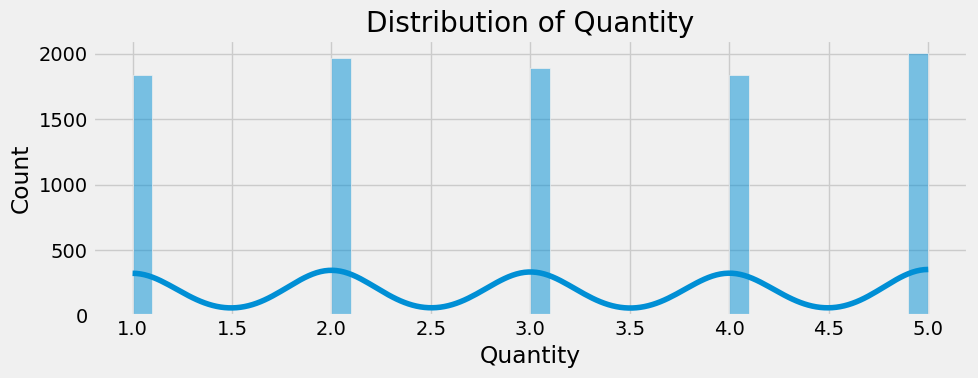

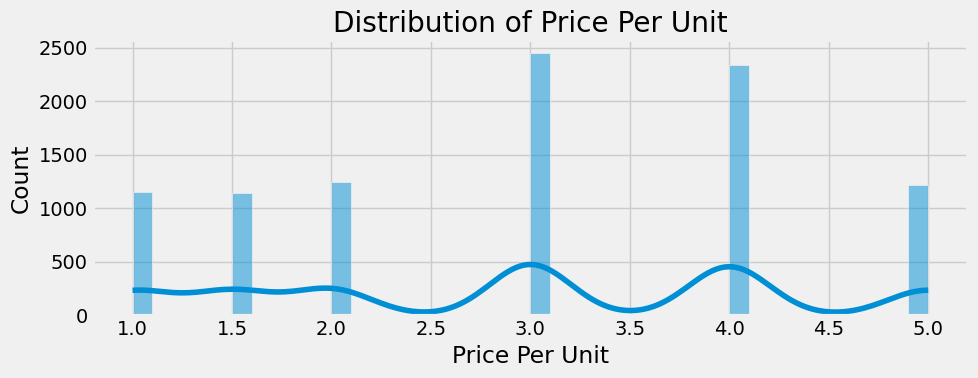

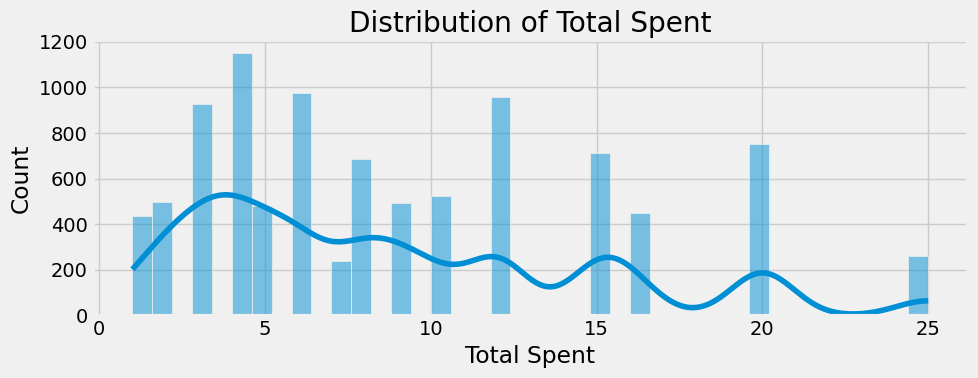

In [25]:
# Numerical Features Exploration

# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

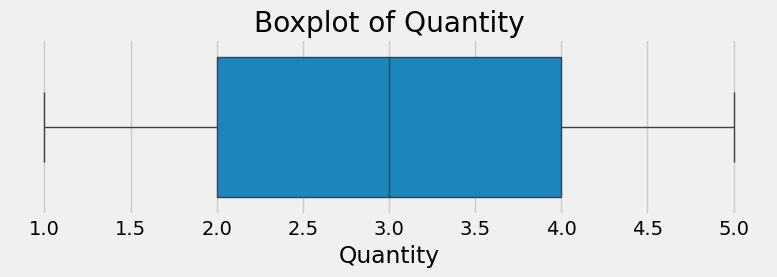

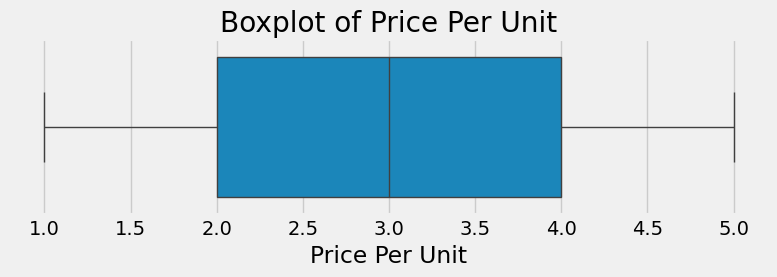

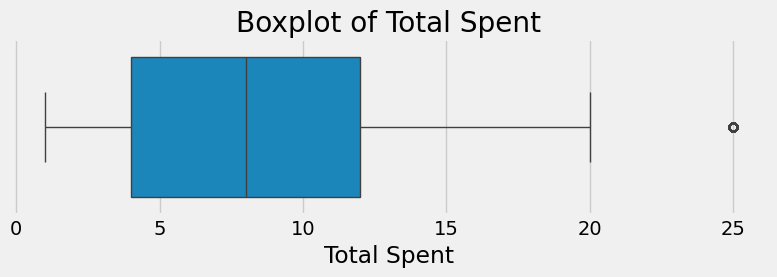

In [26]:
# Boxplot
for col in num_cols:
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

In [27]:
# Skewness
skewness = df[num_cols].skew().sort_values(ascending=False)
print('📌 Skewness for every numerical column:')
skewness

📌 Skewness for every numerical column:


Total Spent       0.828165
Price Per Unit    0.008195
Quantity         -0.001778
dtype: float64

In [28]:
# Outliers

df_out = df.copy()
num_cols_out = df_out.select_dtypes(include=np.number).columns.tolist()

# 1) IQR
Q1 = df_out[num_cols_out].quantile(0.25)
Q3 = df_out[num_cols_out].quantile(0.75)
IQR = Q3 - Q1

condition_iqr = ~(
    (df_out[num_cols_out] < (Q1 - 1.5*IQR)) |
    (df_out[num_cols_out] > (Q3 + 1.5*IQR))
).any(axis=1)

df_iqr_clean = df_out[condition_iqr]
print("Shape after IQR outlier removal:", df_iqr_clean.shape)

Shape after IQR outlier removal: (9280, 9)


In [29]:
from scipy.stats import zscore

# 2) Z-Score

z_scores = np.abs(zscore(df_out[num_cols_out], nan_policy='omit'))
condition_z = (z_scores < 3).all(axis=1)

df_z_clean = df_out[condition_z]
print("Shape after Z-score outlier removal:", df_z_clean.shape)

Shape after Z-score outlier removal: (9540, 9)


In [30]:
# IQR is the better option
df = df_iqr_clean.copy()
df.shape

(9280, 9)

In [31]:
# Duplicates
print("Number of duplicate rows:", df.duplicated().sum())

df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

Number of duplicate rows: 0
Shape after dropping duplicates: (9280, 9)


In [32]:
print("✅ Final DataFrame info:")
df.info()

✅ Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 9280 entries, 0 to 9539
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    9280 non-null   object        
 1   Item              9280 non-null   category      
 2   Quantity          9280 non-null   int64         
 3   Price Per Unit    9280 non-null   float64       
 4   Total Spent       9280 non-null   float64       
 5   Payment Method    9280 non-null   category      
 6   Location          9280 non-null   category      
 7   Transaction Date  9280 non-null   datetime64[ns]
 8   is_imputed        9280 non-null   bool          
dtypes: bool(1), category(3), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 471.9+ KB


In [33]:
print("📊 Summary statistics (Numerical):")
df.describe().T

📊 Summary statistics (Numerical):


,count,mean,min,25%,50%,75%,max,std
Quantity,9280.0,2.966703,1.0,2.0,3.0,4.0,5.0,1.397298
Price Per Unit,9280.0,2.891379,1.0,2.0,3.0,4.0,5.0,1.249076
Total Spent,9280.0,8.473168,1.0,4.0,7.5,12.0,20.0,5.438968
Transaction Date,9280,2023-07-01 22:00:03.103448064,2023-01-01 00:00:00,2023-04-01 00:00:00,2023-07-02 00:00:00,2023-10-02 00:00:00,2023-12-31 00:00:00,NaN


In [34]:
print("🔠 Summary statistics (Categorical):")
df.describe(include=['category', 'object']).T

🔠 Summary statistics (Categorical):


,count,unique,top,freq
Transaction ID,9280,9280,TXN_1961373,1
Item,9280,9,Juice,1124
Payment Method,9280,4,Not Recorded,2933
Location,9280,3,Not Recorded,3684


In [35]:
# ** Feature Engineering **

df_fe = df.copy()

In [36]:
# Feature creation - Time-Based Feature Engineering

if "Transaction Date" in df_fe.columns:
    df_fe["Transaction Date"] = pd.to_datetime(df_fe["Transaction Date"])

    # Extract Time-Based Features
    df_fe["year"] = df_fe["Transaction Date"].dt.year
    df_fe["month"] = df_fe["Transaction Date"].dt.month
    df_fe["day"] = df_fe["Transaction Date"].dt.day
    df_fe["weekday"] = df_fe["Transaction Date"].dt.dayofweek
    df_fe["is_weekend"] = df_fe["weekday"].isin([5, 6]).astype(int)

    # Extract seasons
    def get_season(m):
        if m in [12, 1, 2]: return "Winter"
        if m in [3, 4, 5]: return "Spring"
        if m in [6, 7, 8]: return "Summer"
        if m in [9, 10, 11]: return "Fall"

    df_fe["season"] = df_fe["month"].apply(get_season)

print("\n📌 Time-based features added (year, month, day, weekday, hour, is_weekend, season)")


📌 Time-based features added (year, month, day, weekday, hour, is_weekend, season)


In [37]:
df_fe.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,is_imputed,year,month,day,weekday,is_weekend,season
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,False,2023,9,8,4,0,Fall
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,False,2023,5,16,1,0,Spring
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19,False,2023,7,19,2,0,Summer
3,TXN_7034554,Salad,2,5.0,10.0,Not Recorded,Not Recorded,2023-04-27,False,2023,4,27,3,0,Spring
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,False,2023,6,11,6,1,Summer


In [38]:
# Feature transformation

from sklearn.preprocessing import StandardScaler

# Fix Skewness using Log Transform
skewed_cols = df_fe.select_dtypes(include=np.number).skew().sort_values(ascending=False)
high_skew_cols = skewed_cols[abs(skewed_cols) > 0.5].index.tolist()

# Exclude binary columns
high_skew_cols = [col for col in high_skew_cols if df_fe[col].nunique() != 2]

print("\n📌 Highly Skewed Columns:", high_skew_cols)

# Applying log1p to columns with large skewness
for col in high_skew_cols:
    df_fe[col + " Log"] = np.log1p(df_fe[col].clip(lower=0))

print("📌 Log-transformed versions created for skewed columns.")


📌 Highly Skewed Columns: ['Total Spent']
📌 Log-transformed versions created for skewed columns.


In [39]:
# Feature encoding

# Get all categorical columns
cat_cols_fe = df_fe.select_dtypes(include=['category', 'object']).columns.tolist()

# Exclude the unique identifier
cat_cols_fe = [col for col in cat_cols_fe if col != 'Transaction ID']

print("\n📌 Categorical columns to encode:", cat_cols_fe)

df_fe = pd.get_dummies(df_fe, columns=cat_cols_fe, drop_first=True)

print("📌 One-Hot Encoding applied to categorical columns.")
print("Shape after encoding:", df_fe.shape)


📌 Categorical columns to encode: ['Item', 'Payment Method', 'Location', 'season']
📌 One-Hot Encoding applied to categorical columns.
Shape after encoding: (9280, 28)


In [40]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9280 entries, 0 to 9539
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction ID                 9280 non-null   object        
 1   Quantity                       9280 non-null   int64         
 2   Price Per Unit                 9280 non-null   float64       
 3   Total Spent                    9280 non-null   float64       
 4   Transaction Date               9280 non-null   datetime64[ns]
 5   is_imputed                     9280 non-null   bool          
 6   year                           9280 non-null   int32         
 7   month                          9280 non-null   int32         
 8   day                            9280 non-null   int32         
 9   weekday                        9280 non-null   int32         
 10  is_weekend                     9280 non-null   int64         
 11  Total Spent Log       

In [41]:
df_fe.describe().T.head()

,count,mean,min,25%,50%,75%,max,std
Quantity,9280.0,2.966703,1.0,2.0,3.0,4.0,5.0,1.397298
Price Per Unit,9280.0,2.891379,1.0,2.0,3.0,4.0,5.0,1.249076
Total Spent,9280.0,8.473168,1.0,4.0,7.5,12.0,20.0,5.438968
Transaction Date,9280,2023-07-01 22:00:03.103448064,2023-01-01 00:00:00,2023-04-01 00:00:00,2023-07-02 00:00:00,2023-10-02 00:00:00,2023-12-31 00:00:00,NaN
year,9280.0,2023.0,2023.0,2023.0,2023.0,2023.0,2023.0,0.0


In [42]:
# Reset the index of the DataFrame
df_fe = df_fe.reset_index(drop=True)

# Drop unnecessary columns
df_fe = df_fe.drop(columns=['Transaction ID', 'Transaction Date'])

print("📌 Index has been successfully reset and unnecessary columns are droped.")
df_fe

📌 Index has been successfully reset and unnecessary columns are droped.


,Quantity,Price Per Unit,Total Spent,is_imputed,year,month,day,weekday,is_weekend,Total Spent Log,...,Item_Tea,Item_Other,Payment Method_Credit Card,Payment Method_Digital Wallet,Payment Method_Not Recorded,Location_Takeaway,Location_Not Recorded,season_Spring,season_Summer,season_Winter
0,2,2.0,4.0,False,2023,9,8,4,0,1.609438,...,False,False,True,False,False,True,False,False,False,False
1,4,3.0,12.0,False,2023,5,16,1,0,2.564949,...,False,False,False,False,False,False,False,True,False,False
2,4,1.0,4.0,False,2023,7,19,2,0,1.609438,...,False,False,True,False,False,False,False,False,True,False
3,2,5.0,10.0,False,2023,4,27,3,0,2.397895,...,False,False,False,False,True,False,True,True,False,False
4,2,2.0,4.0,False,2023,6,11,6,1,1.609438,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,2,2.0,4.0,False,2023,8,30,2,0,1.609438,...,False,False,False,False,True,False,True,False,True,False
9276,3,1.0,3.0,False,2023,6,2,4,0,1.386294,...,False,True,False,True,False,False,True,False,True,False
9277,4,2.0,8.0,False,2023,3,2,3,0,2.197225,...,False,False,False,True,False,False,True,True,False,False
9278,3,1.0,3.0,False,2023,12,2,5,1,1.386294,...,False,False,False,True,False,False,True,False,False,True


In [43]:
# Extract csv file after preprocessing

df_fe.to_csv('clean_cafe_sales.csv')